# PML - Abgabe Projekt 3
## Andrika Deeka Kapoor (215127) und Merve Altuntas (203480)

1 - Import statements

In [45]:
import seaborn as sns
import joblib 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Phase 1: Anomaly detection

Found anomalies:

    Age  Sex       ALB       ALP       ALT       AST       BIL       CHE  \
5    32  0.0 -0.380951 -1.331635 -0.775863 -1.066318  0.185162  0.655633   
9    32  0.0 -0.201045  1.184528 -0.679102 -1.032800  3.065740 -1.687789   
22   34  0.0 -0.133580 -0.044296  0.740062  0.117983  1.581425  1.196826   
23   34  0.0  0.023838 -1.167792  3.487004  1.894436  0.059373 -0.358449   
27   34  0.0 -3.214468 -1.431112 -0.206048 -1.468534 -0.758259 -0.973203   
37   35  0.0  1.215714  0.388718 -0.474829  0.196192  4.311055  0.382409   
42   35  0.0 -3.484327  1.927673 -0.120038 -0.161333 -0.179627 -0.983712   
45   36  0.0 -0.358462  0.652037  3.798790  1.972644 -0.053838  1.858869   
53   37  0.0 -2.674750  2.337281 -0.878000 -1.367980 -1.060153 -1.430328   
59   37  0.0 -1.055598 -0.284209 -0.447951  0.296746 -0.368311 -1.393548   
67   37  0.0  0.068814  0.394569  0.992716  1.615119  0.373846 -0.269126   
84   39  0.0  0.136279  1.406886  2.954818  3.503298 -0.280259  0.6661

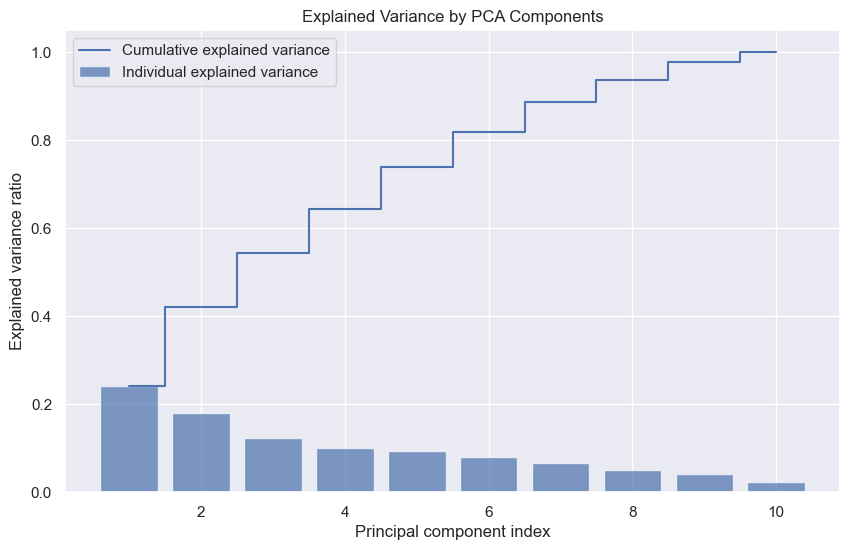

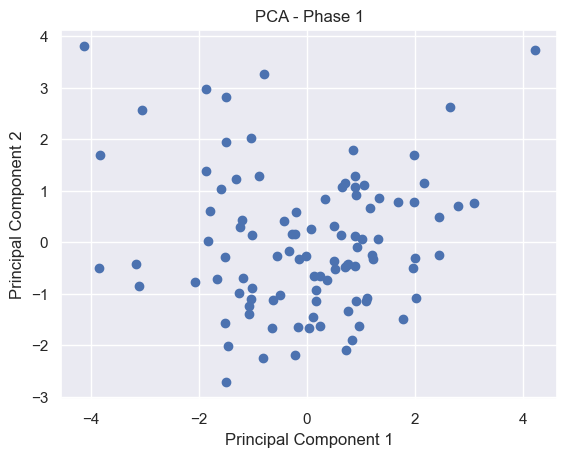

In [46]:
def preprocess_dataset(dataset):
    # Loading data
    dataset_phase = pd.read_csv(dataset)
    # Encoding categorical data

    # Encoding categorical data (Sex)
    label_encoder = LabelEncoder()
    dataset_phase['Sex'] = label_encoder.fit_transform(dataset_phase['Sex'])

    # Removing unnecessary columns (Index)
    dataset_phase.drop('Unnamed: 0', axis=1, inplace=True)  # Dropping an irrelevant index column

    return dataset_phase


# Defining expected categories for gender
expected_categories = ['m', 'f']
dataset = 'hcvdat11_Anomaly.csv'
data_phase1 = preprocess_dataset(dataset)

# Standardizing the numerical data
scaler = StandardScaler()
numerical_features = data_phase1.columns[1:]  # Excluding the first column
data_phase1[numerical_features] = scaler.fit_transform(data_phase1[numerical_features])

# Performing PCA
pca = PCA(n_components=10)  # Using 10 components
pca_data_phase1 = pca.fit_transform(data_phase1[numerical_features])

# Save the PCA model
joblib.dump(pca, 'pca_model_phase1.pkl')  # Saving the model to a file

# Building an Anomaly Detection Model
model_anomaly = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0,
                                random_state=42)  # Initializing the Isolation Forest model
outliers = model_anomaly.fit(pca_data_phase1)  # Fitting the model to the PCA-transformed data
# finding the values of the scores and anomaly column
data_phase1['scores'] = model_anomaly.decision_function(pca_data_phase1)
data_phase1['anomaly'] = model_anomaly.predict(pca_data_phase1)

# Printing the anomalies. if -1, then there is an anomaly
anomaly = data_phase1.loc[data_phase1['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print("Found anomalies:\n")
print(anomaly)

print("Amount of anomalies")
print(anomaly.shape[0])

print("Isolation Forest model was trained on the first 10 principal components")

# Variance explained by each component
variance_explained = pca.explained_variance_ratio_

# Plotting the variance explained by each PCA component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.7, align='center',
        label='Individual explained variance')
plt.step(range(1, len(variance_explained) + 1), variance_explained.cumsum(), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Explained Variance by PCA Components')
plt.show()

# Visualization of the first two PCA components
plt.scatter(pca_data_phase1[:, 0], pca_data_phase1[:, 1])  # Plotting the first two principal components
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Phase 1')
plt.show()  # Displaying the plot


**Would it make sense to use a reduced number of Principal Components instead of the original
features?**

Insights from the PCA plot:
1. Cumulative explained variance: The graphic indicates that the first few primary components account for a significant portion of the total variance. For example, the first two components explain more than half of the variance. This shows that a smaller selection of components may be sufficient to explain the major patterns in the data.

2. Diminishing Returns: The plot shows a threshold of diminishing returns at which the growth in cumulative explained variance decreases dramatically. This point is often seen as a reasonable choice for lowering dimensionality without major loss of information.  Conclusion:


In conclusion, it would make sense to use a reduced number of principal components for the initial anomaly detection model, ensuring that the majority of the variance is captured while simplifying the model. Care should be taken to balance the benefits of dimensionality reduction with the risk of losing information relevant to detecting subtle but important anomalies in the blood data.



## Phase 2: Cluster Analysis

C:\Users\merve\AppData\Local\Temp\ipykernel_17592\1766643070.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


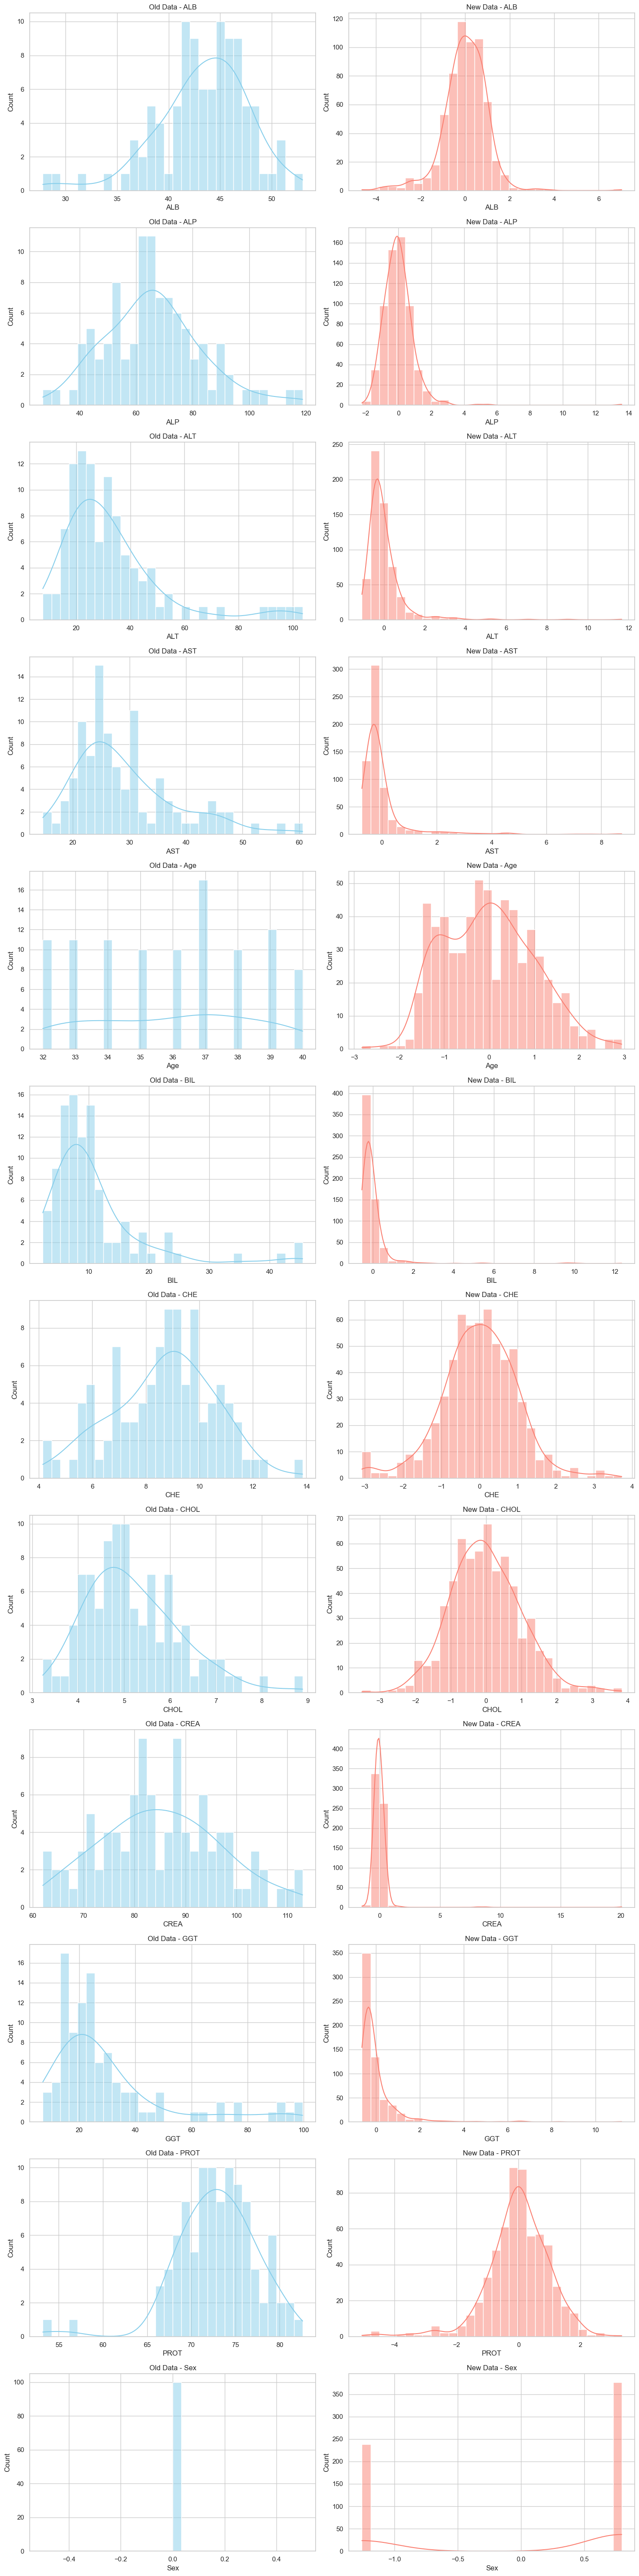

In [47]:
# Define the preprocess_dataset function
def preprocess_dataset_phase2(dataset_path):
    dataset = pd.read_csv(dataset_path)
    label_encoder = LabelEncoder()
    # If 'Sex' is a categorical variable that needs encoding
    if 'Sex' in dataset.columns:
        dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
    # index column that should be removed
    if 'Unnamed: 0' in dataset.columns:
        dataset.drop('Unnamed: 0', axis=1, inplace=True)
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    dataset_imputed = imputer.fit_transform(dataset)
    # Scale the data
    scaler = StandardScaler()
    dataset_scaled = scaler.fit_transform(dataset_imputed)
    dataset_preprocessed = pd.DataFrame(dataset_scaled, columns=dataset.columns)
    return dataset_preprocessed

# Preprocess the old dataset
df_old_preprocessed = preprocess_dataset('hcvdat11_Anomaly.csv')  

# Preprocess the new dataset
df_new_preprocessed = preprocess_dataset_phase2('hcvdat22_Clustering.csv')  

# Now we have preprocessed the datasets
# plot the histograms
sns.set(style="whitegrid")
common_features = set(df_old_preprocessed.columns).intersection(df_new_preprocessed.columns)
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(15, 5 * num_features), constrained_layout=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each feature and create a histogram for old and new data
for i, feature in enumerate(sorted(common_features)):  # Sort to ensure matching order
    # Old data histogram
    sns.histplot(df_old_preprocessed[feature], bins=30, kde=True, color="skyblue", ax=axes[2*i])
    axes[2*i].set_title(f'Old Data - {feature}')

    # New data histogram
    sns.histplot(df_new_preprocessed[feature], bins=30, kde=True, color="salmon", ax=axes[2*i+1])
    axes[2*i+1].set_title(f'New Data - {feature}')

    # Set labels
    axes[2*i].set_xlabel(feature)
    axes[2*i].set_ylabel('Count')
    axes[2*i+1].set_xlabel(feature)
    axes[2*i+1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


Not retrained PCA

Imputation Accuracy (Mean Squared Error) for each feature:
{'ALB': 26.516018817917477, 'ALP': 648.0799844105989, 'ALT': 305.0557840512151, 'CHOL': 1.6996521777067026, 'PROT': 20.374641947033364}


C:\Programme_Studium_MIM\Anaconda\Anaconda_Software\envs\Projekt_3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Programme_Studium_MIM\Anaconda\Anaconda_Software\envs\Projekt_3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


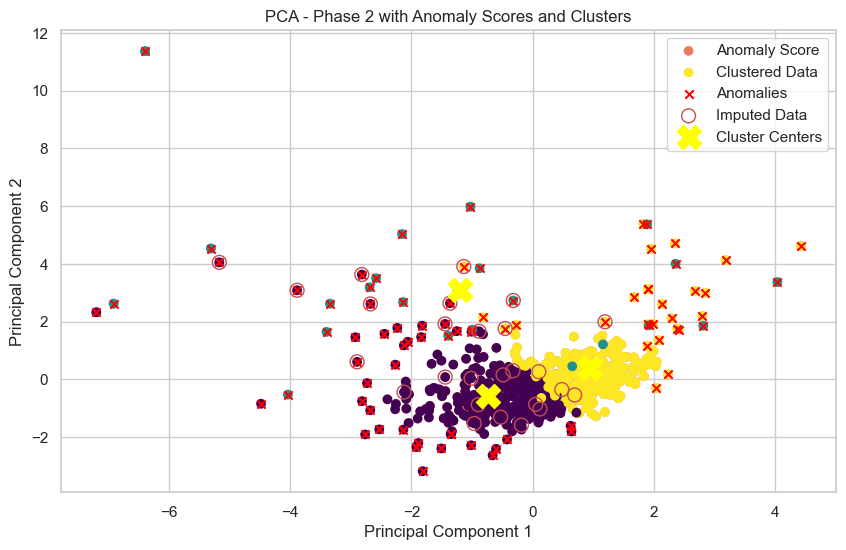

In [48]:
# Load and preprocess the dataset
def preprocessing_phase2_pca(dataset):
    data_phase2 = preprocess_dataset(dataset)

    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data_phase2), columns=data_phase2.columns) 
    
    # Creating a mask for imputed data
    mask_imputed = np.isnan(data_phase2).any(axis=1)
    
    # Estimating the accuracy of imputation
    imputation_accuracy = {}
    for column in data_imputed.columns:
        if data_phase2[column].dtype != 'object' and data_phase2[column].isnull().any():
            # Original non-missing values
            original_values = data_phase2[column].dropna()
    
            # Mask a portion of non-missing data
            mask = original_values.sample(frac=0.1).index  # Mask 10% of non-missing data
            data_phase2.loc[mask, column] = np.nan
    
            # Impute missing values
            imputed_values = imputer.fit_transform(data_phase2[[column]])[mask]
    
            # Calculate the mean squared error
            mse = mean_squared_error(original_values.loc[mask], imputed_values)
            imputation_accuracy[column] = mse
    
    # Display imputation accuracy
    print("Imputation Accuracy (Mean Squared Error) for each feature:")
    print(imputation_accuracy)
    
    # Scaling the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)
    
    return data_scaled, mask_imputed

# perfoming cluster analysis and anomaly detection
def processing(data_clustering):
    # Cluster Analysis with KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(data_clustering)
    
    # Retrain the Isolation Forest model on the first two principal components for visualization
    model_anomaly = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, random_state=42)
    model_anomaly.fit(data_clustering[:, :2])
    
    # Apply the anomaly detection model to the PCA-transformed data from phase two
    anomaly_scores_phase2 = model_anomaly.decision_function(data_clustering[:, :2])
    anomalies_phase2 = model_anomaly.predict(data_clustering[:, :2])

    return kmeans, clusters, anomaly_scores_phase2, anomalies_phase2

# Visualization of the first two PCA components with anomaly scores and clusters
def visualization(data_clustering, anomaly_scores, clusters, anomalies_phase2, mask_imputed, kmeans, version):
    plt.figure(figsize=(10, 6))
    plt.scatter(data_clustering[:, 0], data_clustering[:, 1], c=anomaly_scores, cmap='coolwarm', marker='o', label='Anomaly Score')
    plt.scatter(data_clustering[:, 0], data_clustering[:, 1], c=clusters, cmap='viridis', marker='o', label='Clustered Data')
    anomaly_mask = anomalies_phase2 == -1
    plt.scatter(data_clustering[anomaly_mask, 0], data_clustering[anomaly_mask, 1], c='red', marker='x', label='Anomalies')
    plt.scatter(data_clustering[mask_imputed, 0], data_clustering[mask_imputed, 1], facecolors='none', edgecolors='r', s=100, label='Imputed Data')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Cluster Centers', marker='X')
    
    if version == "old":
        plt.title('PCA - Phase 2 with Anomaly Scores and Clusters')
    elif version == "new":
        plt.title('PCA - New Data with Anomaly Scores and Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


# preprocess the data
data_scaled, mask_imputed = preprocessing_phase2_pca('hcvdat22_Clustering.csv')

# the first column of the data_scaled array should be excluded based on the PCA training
data_scaled_for_pca = data_scaled[:, 1:]

# PCA Transformation (using PCA model from Phase 1)
pca = joblib.load('pca_model_phase1.pkl')  # Adjust the path to your PCA model
data_clustering_pca = pca.transform(data_scaled_for_pca)

# calling the methods
kmeans, clusters, anomaly_scores_phase2, anomalies_phase2  = processing(data_clustering_pca)
visualization(data_clustering_pca, anomaly_scores_phase2, clusters, anomalies_phase2, mask_imputed, kmeans, "old")

Retrained PCA

Imputation Accuracy (Mean Squared Error) for each feature:
{'ALB': 25.299931455126092, 'ALP': 2431.1913215827644, 'ALT': 2584.094342074334, 'CHOL': 1.8069765881098676, 'PROT': 28.839568684492814}


C:\Programme_Studium_MIM\Anaconda\Anaconda_Software\envs\Projekt_3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


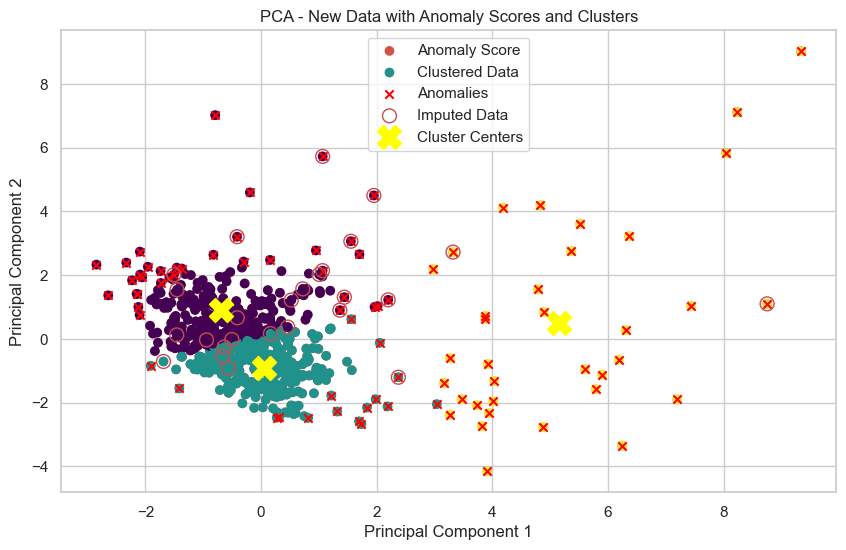

In [49]:
# Load and preprocess the new dataset
data_scaled, mask_imputed = preprocessing_phase2_pca('hcvdat22_Clustering.csv')

# Retrain PCA on the new data
pca = PCA(n_components=2) 
data_clustering_pca_new = pca.fit_transform(data_scaled)

# calling the methods
kmeans_new, clusters_new, anomaly_scores_new, anomalies_new = processing(data_clustering_pca_new)
visualization(data_clustering_pca_new, anomaly_scores_new, clusters_new, anomalies_new, mask_imputed, kmeans_new, "new")


**Would it make sense to retrain the PCA for the new data?**

Considering these observations, we can see that the new dataset has significant differences in feature distribution compared to the old dataset.
 Since PCA is sensitive to data variance and size, such changes can affect the principal components derived from the PCA.
 This difference is significant enough to indicate that a PCA model trained on  old data may not optimally represent the structure of  new data.
Retraining the PCA is recommended as it is likely to capture the most relevant axes of variation in the new dataset.
 Retraining the PCA is especially important when subsequent analysis steps, such as clustering or anomaly detection, are based on key components that accurately reflect the underlying structure of the data.
 New PCA components may lead to different findings and interpretations, especially when analyzing biomedical data where such differences may be clinically important.

**Compare and discuss the results of your Anomaly Detection and your Cluster Analysis.**

The plot shows that cluster analysis was applied to the PCA-transformed data, grouping the data points into clusters (color-coded). Outliers have been found using anomaly detection and marked with a 'x'.

When comparing these, a few patterns show up:

Some anomalies are found near the borders of clusters or far away from any cluster center, which is understandable given that they do not fit into any group.
If anomalies happen on a regular basis within a single cluster, this could indicate the presence of a subgroup within the cluster with distinct traits, or it could indicate that the cluster is poorly characterized.
The distribution and placement of anomalies relative to clusters might help to clarify the nature of the data's outliers.

Anomalies inside clusters may be borderline instances, whereas those isolated from any cluster may be more extreme outliers.
Visualizing PCA, Clusters, and Anomalies
The plot correctly visualizes the PCA-transformed data, as follows:

The first two primary components function as axes, substantially reducing dimensionality for display purposes.
The color coding by cluster enables for easy identification of data groupings.
Anomalies are clearly defined, indicating their distribution in relation to the clusters.
Imputed data points are tagged in an unusual manner, allowing you to determine if they behave like regular data points or are flagged as anomalies.

Decision Boundary

The anomaly detector's decision border has not been properly plotted. Isolation Forest does not have a simple geometric boundary like some other models, but the distribution of anomaly scores can provide insight into where the boundary might be.

In conclusion, the visualization and models used give a thorough perspective of the data's structure, emphasizing normal groupings, prospective subgroups, and outliers. The inclusion of imputed points also helps to evaluate the impact of imputation on the analysis.


## Phase 3: Decision Tree-Anomaly Detection Pipeline

Accuracy of Decision Tree Model: 0.8455284552845529


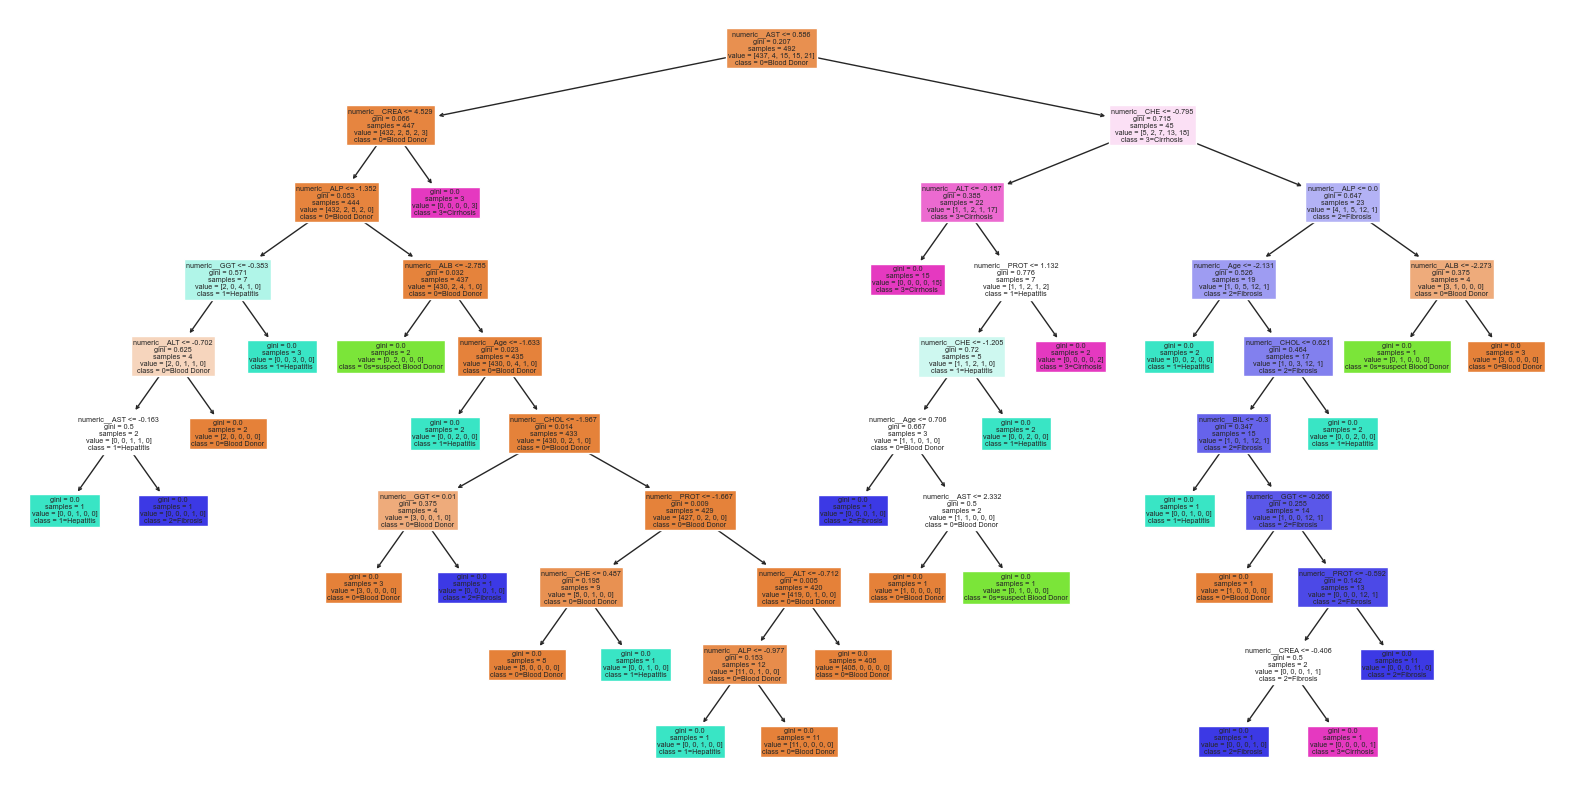

C:\Programme_Studium_MIM\Anaconda\Anaconda_Software\envs\Projekt_3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\merve\AppData\Local\Temp\ipykernel_17592\2982355339.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(dt_pipeline_predictions, palette='coolwarm')


     Age  Sex   ALB    ALP   ALT    AST   BIL   CHE  CHOL  CREA    GGT  PROT  \
248   55    1  28.1   65.5  16.6   17.5   2.8  5.58  4.39  65.0   26.2  62.4   
365   39    0  31.4  106.0  16.6   17.0   2.4  5.95  5.30  68.0   22.9  72.3   
432   48    0  43.7   50.1  17.3   26.3   8.1  8.15  5.38  64.0   13.4  73.1   
610   62    0  32.0  416.6   5.9  110.3  50.0  5.57  6.30  55.7  650.9  68.5   
132   44    1  35.5   81.7  27.5   29.5   6.4  8.81  6.65  83.0   24.1  68.0   

     Anomaly Prediction Classifier (Decision Tree) Prediction  \
248                   1                         0=Blood Donor   
365                   1                         0=Blood Donor   
432                   1                         0=Blood Donor   
610                  -1                           3=Cirrhosis   
132                   1                         0=Blood Donor   

     Clustering Prediction  Actual Labels  
248                      1  0=Blood Donor  
365                      1  0=Blood Dono

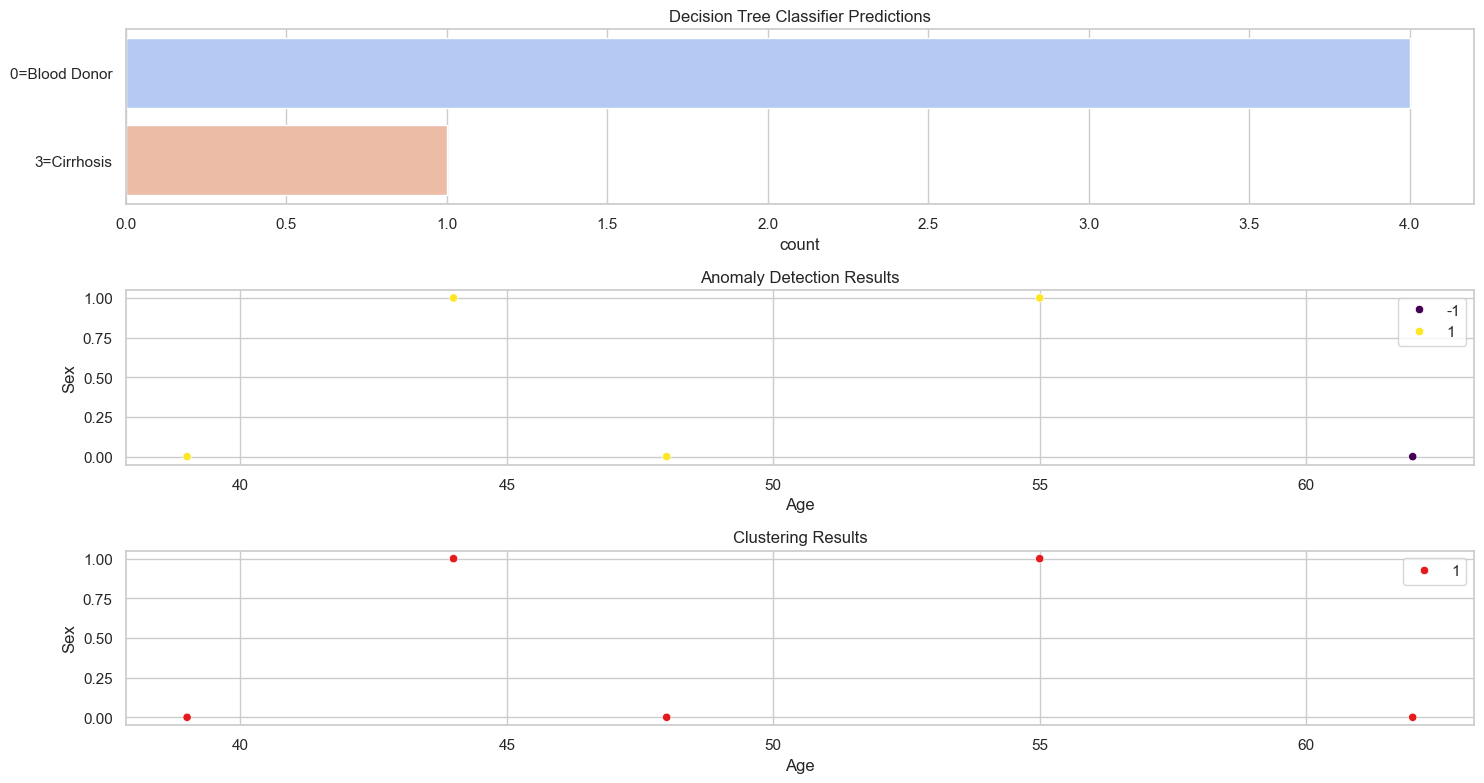

In [51]:
# Load the dataset
file_path = 'hcvdat33_Complete.csv' 
dataset_3 = pd.read_csv(file_path)

# one hot encoding for the Gender
label_encoder = LabelEncoder()
if 'Sex' in dataset_3.columns:
    dataset_3['Sex'] = label_encoder.fit_transform(dataset_3['Sex'])

# Preprocess dataset
labels = dataset_3['Category']
features = dataset_3.drop(columns=['Category', 'Unnamed: 0'])  

# defining numerical and categorical columns
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

# imputing missing values in numerical columns and perform scaling 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# imputing categorical column
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)])

# Preprocessed features (impute and scale)
X_preprocessed = preprocessor.fit_transform(features)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, labels, test_size=0.2, random_state=42)

# Training a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Model Evaluation
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree Model: {accuracy}")

# Visualizing of the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=preprocessor.get_feature_names_out(), class_names=dt_classifier.classes_)
plt.show()

# Anomaly Detection
anomaly_detector = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, random_state=42)
anomaly_detector.fit(X_preprocessed)

# Building a Pipeline 
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(features, labels)

# Testing the pipeline with a sample from the test set
sample_test_features = features.sample(5, random_state=42)

# predicting the labels with decision Tree, anomaly detection and clustering
dt_pipeline_predictions = dt_pipeline.predict(sample_test_features)
anomaly_predictions = anomaly_detector.predict(preprocessor.transform(sample_test_features))
clusters_prediction = kmeans.predict(sample_test_features.iloc[:, :10])

# Comparison with actual Labels
actual_labels = labels.loc[sample_test_features.index]
comparison_data = sample_test_features.copy()
comparison_data['Anomaly Prediction'] = anomaly_predictions
comparison_data['Classifier (Decision Tree) Prediction'] = dt_pipeline_predictions
comparison_data['Clustering Prediction'] = clusters_prediction
comparison_data['Actual Labels'] = actual_labels

print(comparison_data)

# y_test are the true labels and y_pred are the predictions from the decision tree
print(classification_report(y_test, y_pred, target_names=dt_classifier.classes_))

# Plotting the results
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
sns.countplot(dt_pipeline_predictions, palette='coolwarm')
plt.title('Decision Tree Classifier Predictions')

plt.subplot(3, 1, 2)
sns.scatterplot(x=sample_test_features.iloc[:, 0], y=sample_test_features.iloc[:, 1], hue=anomaly_predictions ,palette='viridis', marker='o')
plt.title('Anomaly Detection Results')

plt.subplot(3, 1, 3)
sns.scatterplot(x=sample_test_features.iloc[:, 0], y=sample_test_features.iloc[:, 1], hue=clusters_prediction, palette='Set1', marker='o')
plt.title('Clustering Results')

plt.tight_layout()
plt.show()

**Compare and discuss the classifier result with the anomaly detection results and the clustering results.**

Four of the five samples that were submitted were flagged by the pipeline as "0=Blood Donor," and none of these four samples were flagged as anomalies by the anomaly detection (as indicated by a predicted value of 1). This implies that the model views these samples as normal and that they correspond to the expected data distribution that was taught during training.
The case shown in the fifth sample (index 610) is distinct. The pipeline categorized it as '3=Cirrhosis' and flagged it as an abnormality (as indicated by a prediction of -1). The high results in several tests, such ALP and GGT, suggest that the feature values in this sample mostly depart from the norm. It appears possible that this is a legitimate case of liver illness that differs from the patterns observed in '0=Blood Donor' samples because the anomaly detector detected it and the classifier identified it as 'Cirrhosis'. This pipeline's combination of anomaly detection and a decision tree classifier offers a two-tiered classification method:

Anomaly detection: This serves as a preliminary filter, identifying data points that deviate considerably from the training set's distribution of data. These could be unusual situations, unique ways that conditions are presented, or mistakes in the data.

Decision Tree Classifier: The decision tree uses the patterns it has discovered to classify data points that are not marked as anomalies. Additionally, the decision tree is visible, giving precise guidelines that guided each classification a crucial feature.

If you compare the anomaly prediction with the clustering prediction, you can see that they are the same. With an accuracy of approx. 84%, the Decision Tree Classifier performed good.